In [242]:
from PIL import Image, ImageFont, ImageDraw, ImageFilter

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
import os
import csv
import json
import cv2
import numpy as np

In [243]:
## set default paths
font_path = "fonts"
base = "ita_passport_bg.png"
output_path = "out"
#xml_path = "out/xml"
path_backgrounds = 'backgrounds'
list_backgrouns = os.listdir(path_backgrounds)
background = list_backgrouns[random.randint(0, len(list_backgrouns)-1)]
font_styles = os.listdir(font_path)
print(font_styles)
data_file = open("data/data.csv", "r", newline='')

['Hack-Italic.ttf', 'Hack-Regular.ttf', 'Hack-Bold.ttf', 'Hack-BoldItalic.ttf']


In [244]:
## preparing path
font_style = os.path.join(font_path, font_styles[2])

#loading font
font_size = 12
font = ImageFont.truetype(font_style, font_size)
char_width = 7

## color and coordinates definition
color = (0,0,0) #black

csv_reader = csv.reader(data_file)
# per studiare meglio il comportamento del codice, chiedo di effettuare le prossime operazioni solo sulla prima riga del file csv --> faccio un solo passaporto di prova
head_csv_reader = next(csv_reader)

pos_dict_list = []

Passport Data:  ['BARRACO', 'MARIO SALVATORE', 'ITALIANA', '8/11/1904', 'M', '6/13/2016', '6/13/2026', 'MILANO']
Tipo di errori:  [0, 0]
Nome del file:  forged_passport_test.png


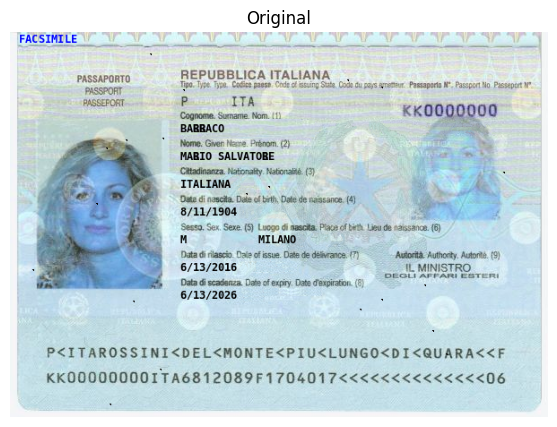

In [245]:
passport_data = head_csv_reader
print("Passport Data: ", passport_data)

image = Image.open(base)

draw = ImageDraw.Draw(image)

color_facsimile = (255, 0, 0)
draw.text((10,0), "FACSIMILE    ", color_facsimile, font = font)

# forged_rnd mi definisce i tipi di errori da inserire nel passaporto che lo rendono falso
# random number: forged_rnd = 0 => elementi spuri nel passaporto ("passaporto sporco")
#                forged_rnd = 1 => colore diverso della scritta                
#                forged_rnd = 2 => lettere scritte una sopra l'altra
#                forged_rnd = 3 => caratteri in linee sfalsate   

forged_rnd = [random.randint(0,3),random.randint(0,3)]
print("Tipo di errori: ", forged_rnd)
forged_rnd = [0,1]

if 3 in forged_rnd:
    # numero totale di caratteri di passport data
    length_tot = 0
    for i in range(len(passport_data)):
        length_tot += len(passport_data[i])
    print("Numero di caratteri da sfalsare: ", length_tot)
    # num_stagger_char numero di caratteri sfalsati da inserire nel testo --> max 5
    num_stagger_char = random.randint(1, 5)
    stagger_char_indexes = []
    for i in range(0, num_stagger_char):
        stagger_char_indexes.append(random.randint(0, length_tot - 1))
    print("Indici dei caratteri sfalsati: ", stagger_char_indexes)

if 1 in forged_rnd:
    # numero di caratteri di cui cambiare il colore
    num_diff_color_chars = random.randint(1, 5)
    # indice dei caratteri di cui cambiare il colore
    diff_color_char_indexes = []
    for i in range(0, num_diff_color_chars):
        diff_color_char_indexes.append(random.randint(0, length_tot - 1))
    print("Indice dei caratteri di cui cambiare il colore: ", diff_color_char_indexes)
        
file_name = "forged_passport_test.png"
print("Nome del file: ", file_name)
current_char = 0
for i in range(len(passport_data)):
    for j in range(len(passport_data[i])):

            # 3 in forged_rnd: devo inserire caratteri sfalsati
            if 3 in forged_rnd and current_char in stagger_char_indexes:
                
                # FONT CHANGE
                c_fontstyle = font_style # it's here if we want it to dinamically change one day
                c_fontsize = font_size + random.randint(-2, 2)
                c_font = ImageFont.truetype(c_fontstyle, c_fontsize)

                # CALCOLO DELLE COORDINATE
                if i == 7: # la x per il settimo elemento è diversa (Luogo di nascita traslato di 87 pixels a destra)
                    coord_string = (190 + 87 + j * char_width + random.randint(-2,2), 100 + 31 * 4 + random.randint(-2,2))
                else:
                    coord_string = (190 + j * char_width + random.randint(-2,2), 100 + 31 * i + random.randint(-2,2))
            
                # SCRITTURA DEL TESTO
                # 3 in forged_rnd and 1 in forged_rnd --> colore diverso + sfalsamento dei caratteri
                if 1 in forged_rnd and current_char in diff_color_char_indexes:
                    diff_color = (20,20,20) # valore più vicino al nero che ci sia
                    draw.text(coord_string, passport_data[i][j], diff_color, font = c_font)

                
                # 3 in forged_rnd and 2 in forged_rnd --> sovrascrittura delle lettere + sfalsamento dei caratteri
                elif 2 in forged_rnd and passport_data[i][j]=='S' or passport_data[i][j]=='P' or passport_data[i][j]=='R':
                    draw.text(coord_string, passport_data[i][j], color, font = c_font)
                    draw.text(coord_string, 'B', color, font = c_font)

                # solo 3 in forged_rnd 
                else:
                    draw.text(coord_string, passport_data[i][j], color, font = c_font)
                
                # disegno nell'immagine le bounding boxes
                pos = draw.textbbox(coord_string,  passport_data[i][j], font = c_font) #(left, top, right, bottom) bounding box
                #draw.rectangle(pos, outline = 'blue')

                # scrivo su un file json le bounding box con il relativo path
                pos_dict_list.append(pos)
                    
            else: # 3 not in forged_rnd
                
                # CALCOLO DELLE COORDINATE
                if i == 7:  # la x per il settimo elemento è diversa (Luogo di nascita traslato di 87 pixels a destra)
                    coord_string = (190 + 87 + j * char_width, 100 + 31 * 4)
                else:
                    coord_string = (190 + j * char_width, 100 + 31 * i)
                
                # 1 in forged_rnd --> colore diverso
                if 1 in forged_rnd and current_char in diff_color_char_indexes:
                    diff_color = (20,20,20) # valore più vicino al nero che ci sia
                    draw.text(coord_string, passport_data[i][j], diff_color, font = font)
                    
                    # disegno nell'immagine le bounding boxes
                    pos = draw.textbbox(coord_string,  passport_data[i][j], font = font) #(left, top, right, bottom) bounding box
                    #draw.rectangle(pos, outline = 'blue')
                    
                    # scrivo su un file json le bounding box con il relativo path
                    pos_dict_list.append(pos)
                
                # 2 in forged_rnd --> sovrascrittura delle lettere
                elif 2 in forged_rnd and  passport_data[i][j]=='S' or passport_data[i][j]=='P' or passport_data[i][j]=='R':
                    draw.text(coord_string, passport_data[i][j], color, font = font)
                    draw.text(coord_string, 'B', color, font = font)

                    # disegno nell'immagine le bounding boxes
                    pos = draw.textbbox(coord_string,  passport_data[i][j], font = font) #(left, top, right, bottom) bounding box
                    #draw.rectangle(pos, outline = 'blue')
                    
                    # scrivo su un file json le bounding box con il relativo path
                    pos_dict_list.append(pos)

                else:
                    draw.text(coord_string, passport_data[i][j], color, font = font)

            current_char += 1

# 0 in forged_rnd --> se devo inserire dei valori spuri, ne inserisco un numero randomico compreso tra 1 e 30
if 0 in forged_rnd:
    for i in range(random.randint(1,30)):
        # DEFINIZIONE COORDINATE
        coord_rnd_1 = (random.randint(0,600), random.randint(0,430))
        coord_rnd_2 = (coord_rnd_1[0]+1, coord_rnd_1[1])
        coord_rnd_3 = (coord_rnd_1[0]+1, coord_rnd_1[1]+1)
        coord_rnd_4 = (coord_rnd_1[0]+1, coord_rnd_1[1]+1)
        draw.polygon([coord_rnd_1, coord_rnd_2, coord_rnd_3, coord_rnd_4], fill='black', outline='black')
        
        # scrivo su un file json le bounding box con il relativo path
        pos_dict_list.append([coord_rnd_1, coord_rnd_2, coord_rnd_3, coord_rnd_4])

""" 
Scrittura bounding boxes in file xml

print(pos_dict_list) # formato: xmin, ymin, xmax, ymax
xml_file_name = file_name.split(".")[0]+".xml"
object = ET.Element('object')
for pos in pos_dict_list:
    print(pos)
    xmin, ymin, xmax, ymax = pos

Scrittura Bounding boxes nel file json contenente le annotation

with open(os.path.join(output_path, "annotation.json"),"w") as f :
    json.dump(pos_dict_list, f)

DA COMPLETARE NEL CASO SERVA
"""
image.save(os.path.join(output_path, file_name), quality=100)
image = cv2.imread(os.path.join(output_path, file_name), cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.imshow(image)
ax.set_title('Original')
ax.axis('off')
plt.show()

Tecnica : rotation
Angolo di rotazione:  2


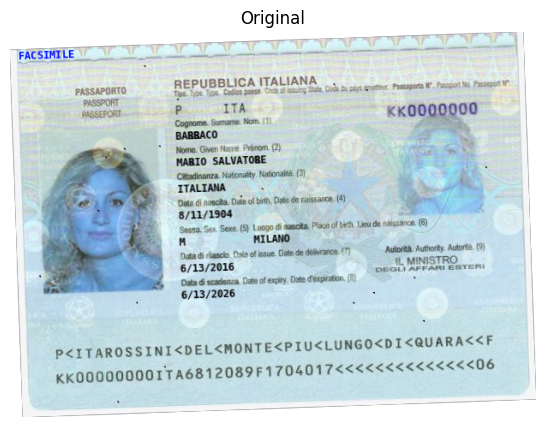

In [246]:
# In alcune immagini andiamo ad inserire una minima rotazione, per evitare che gli unici passaporti leggibili siano quelli posizionati esattamente frontalmente alla telecamera (caso quasi impossibile...)

rnd_tec = ["rotation", "none"]
technique = rnd_tec[random.randint(0,1)]
print("Tecnica :", technique)

if technique == "rotation":

    angle = random.randint(1,5)
    print("Angolo di rotazione: ", angle)

    # grab the dimensions of the image and then determine the centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

    # TODO: calcolo delle nuove bbox
    
file_name = "forged_passport_test_" + technique + ".png"
cv2.imwrite(os.path.join(output_path, file_name), image)

image = cv2.imread(os.path.join(output_path, file_name), cv2.IMREAD_UNCHANGED)
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.imshow(image)
ax.set_title('Original')
ax.axis('off')
plt.show()

Dimensione immagine del passaporto:  (1628, 1080)
Dimensione immagine di background:  (1628, 1080)
Dimensione dimezzata immagine del passaporto:  (814, 540)
Dimensione dimezzata immagine di background:  (814, 540)
Dimensione con margine immagine di background:  (895, 594)


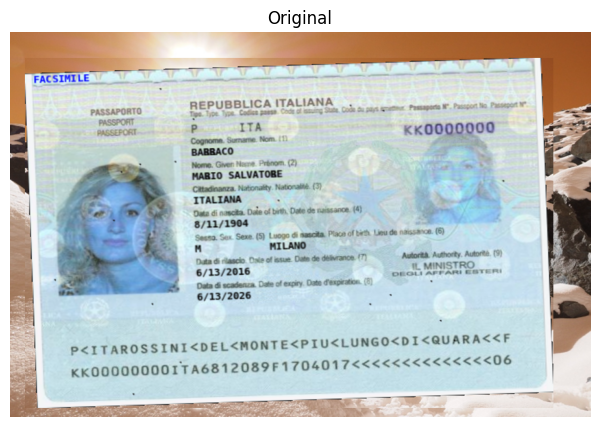

In [247]:
# Permettiamo di avere un background nell'immagine del passporto --> evitiamo che non riconosca più il passaporto con uno sfondo diverso dal bianco

# load images: back and passport image
bg_img = cv2.imread(os.path.join(path_backgrounds, background))
ps_img = cv2.imread(os.path.join(output_path, file_name))
# resive passport
ps_img = cv2.resize(ps_img, (bg_img.shape[1], bg_img.shape[0]))

# Trova i contorni esterni e crea la maschera
ps_image_clone = ps_img.copy()
ps_image_clone = cv2.cvtColor(ps_image_clone, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(ps_image_clone, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Crea la maschera
mask = np.zeros(ps_img.shape[:2], dtype=np.uint8)
cv2.drawContours(mask, contours, 0, 255, -1)

# Erode la maschera per evitare artefatti
mask = cv2.erode(mask, None)

# Copia l'immagine originale in image2 usando la maschera
bg_image_clone = bg_img.copy()
bg_image_clone = cv2.bitwise_and(bg_image_clone, bg_image_clone, mask=cv2.bitwise_not(mask))
bg_image_clone = cv2.add(bg_image_clone, ps_img)

# Scrivo il risultato
file_name = "forged_passport_test_background.png"
cv2.imwrite(os.path.join(output_path, file_name), bg_image_clone)

# Riapro l'immagine con la libreria PIL.Image 
im1 = Image.open(os.path.join(path_backgrounds, background))
im2 = Image.open(os.path.join(output_path, file_name))

# dimezzo le dimensioni per avere immagini meno pesanti
print("Dimensione immagine del passaporto: ", im2.size)
print("Dimensione immagine di background: ", im1.size)
im1 = im1.resize((int(im1.size[0]/2), int(im1.size[1]/2)))
im2 = im2.resize((int(im2.size[0]/2), int(im2.size[1]/2)))
print("Dimensione dimezzata immagine del passaporto: ", im2.size)
print("Dimensione dimezzata immagine di background: ", im1.size)

# faccio un piccolo resize dell'immagine di background per avere un po' più di margine
im1 = im1.resize((int(im1.size[0]*1.1), int(im1.size[1]*1.1)))
print("Dimensione con margine immagine di background: ",im1.size)
position = (random.randint(0,50), random.randint(0,50))
im1.paste(im2, position)
im1.save(os.path.join(output_path, file_name), quality=95)

image = cv2.imread(os.path.join(output_path, file_name), cv2.IMREAD_UNCHANGED)
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.imshow(image)
ax.set_title('Original')
ax.axis('off')
plt.show()